# 从均值方差到有效前沿

这篇教程的主要目的是介绍有效前沿这个理论工具和分析框架。我们由均值方差分析展开，逐步推演到有效前沿。然后，我们又说到有效前沿
在投资或者量化中的应用场景，最后我们也总结了有效前沿的一些问题，尤其是敏感性问题。在教程中，特意加入了一些实验代码，可以让大家
在阅读的过程中有更好的理解。

## 有效前沿

说到有效前沿（有些叫效率边界），就要提到马科维茨的投资组合理论了。

首先介绍下它的三大假设：
- 单一投资期，比如一年
- 流动性很高，无交易成本
- 投资者的选择基于最优均值方差

于是，我们可以开始推导有效前沿，在这之前，我们先约定一些数学符号：
- $r_{f}$：无风险利率
- $\boldsymbol{\mu}$：风险资产预期收益率向量
- $\boldsymbol{f}$：风险资产预期超额收益率向量，即$\boldsymbol{\mu}-r_{f}$
- $\boldsymbol{\Sigma}$：风险资产协方差矩阵
- $\boldsymbol{w}$：风险资产组合权重向量

我们采用三个步骤来得到我们的有效市场前沿，分别是**最小方差组合**、**最优均值方差组合（夏普组合）**以及**有效前沿**。
当我们推导完，大家就会发现有效前沿与前两个组合之间存在有趣的关系，最后我们将用python代码的方式来实现并检验我们得到的结果。

#### 最小方差组合(C组合)

最小方差组合我们简称其C组合，C组合是全额投资组合，意味这$\sum w_{i}$等于1，不过权重可以为负。然后便可以转化为下面的最优化问题：

\begin{align*}
Minimize \qquad & \frac{1}{2} \boldsymbol{w^{T} \Sigma w}\\
s.t \qquad      & \boldsymbol{w^{T}} \boldsymbol{e} = 1
\end{align*}

对目标函数添加拉格朗日乘子然后求微分(注：上面公式里的$\boldsymbol{e}$代表全1的向量)，我们可以得到：

\begin{align*}
\boldsymbol{w_C} &= \boldsymbol{\frac{\Sigma e}{e^T \Sigma^{-1} e}}\\
\sigma_{C}^2          &＝ \boldsymbol{w_C^T \Sigma w_C} = \frac{1}{\boldsymbol{e^T \Sigma^{-1} e}}
\end{align*}

注：对具体数学推导感兴趣的可以看附录。

#### 最优夏普组合(Q组合)

\begin{align*}
Minimize \qquad & SR = \frac{\boldsymbol{w^{T} f}}{(\boldsymbol{w^{T} \Sigma w})^{\frac{1}{2}}}\\
s.t \qquad      & \boldsymbol{w^{T}} \boldsymbol{e} = 1
\end{align*}

和上面的方式一样，只不过这次计算稍微繁琐一点（说繁琐一点实在有些轻瞄淡写，《主动投资组合》附录倒是有更加有趣的推导方式）。

\begin{align*}
\boldsymbol{w_{Q}} = \boldsymbol{ \frac{\boldsymbol{\Sigma^{-1} f}}{f^{T} \Sigma^{-1} e}}
\end{align*}

注：再附录中我们用另外一种方式推导出结果。

#### 有效前沿曲线

有效前沿和最小方差组合差不多，不过多了一个约束条件，即预期收益率约束。

\begin{align*}
Minimize \qquad & \frac{1}{2} \boldsymbol{w^{T} \Sigma w}\\
s.t \qquad      & \boldsymbol{w^{T}} \boldsymbol{e} = 1\\
                & \boldsymbol{w^{T}} \boldsymbol{f} = f_{P}
\end{align*}

在附录中我给出了上述问题的矩阵解，不过可以证明，有效前沿集实际上是最小方差组合与最有夏普组合的线性组合（有点拗口），这种解的形式更加直观，事实上，我就是以这个方式得到的前沿曲线。

\begin{align*}
\boldsymbol{w}_{frontier} = \frac{f_{Q}-f_{P}}{f_{Q}-f_{C}} \boldsymbol{w_{C}} + \frac{f_{P}-f_{C}}{f_{Q}-f_{C}} \boldsymbol{w_{Q}}
\end{align*}

在下面我们模拟了三个风险资产，并用python画出了有效前沿曲线。图上还标注了最小方差组合（C组合）、最优夏普组合（Q组合）以及全额等权组合（E组合）。

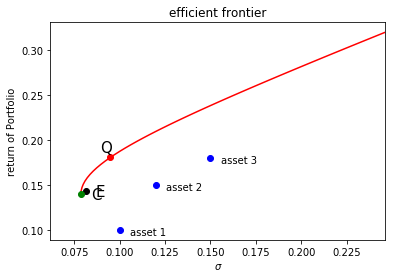

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

rf = 0.05                 # 无风险利率
mu = np.array([0.1,0.15,0.18]) # 预期收益率向量
sigma = np.array([0.1,0.12,0.15])
rou_ab, rou_ac, rou_bc = 0.2, 0.5, -0.2
# 协方差矩阵
C = np.array([[1,      rou_ab,  rou_ac],
              [rou_ab, 1,       rou_bc],
              [rou_ac, rou_bc,  1     ]])
V = np.outer(sigma,sigma)*C

# 前沿曲线绘图函数
def plot_efficient_frontier(rf=rf,mu=mu,V=V,is_subplot=False,show_E=False,strategy=None):
    f = mu-rf                 # 超额收益
    N = len(mu)
    e = np.ones(N)
    V_inverse = np.linalg.inv(V)
    # 等权投资组合
    w_E = e/N
    sigma2_E = w_E.dot(V).dot(w_E)
    sigma_E = np.sqrt(sigma2_E)
    f_E = w_E.dot(f)
    # 最小方差组合
    w_C = V_inverse.dot(e)/e.T.dot(V_inverse).dot(e)
    sigma2_C = w_C.dot(V).dot(w_C)
    sigma_C = np.sqrt(sigma2_C)
    f_C = w_C.dot(f)
    # 夏普组合
    w_Q = V_inverse.dot(f)/f.T.dot(V_inverse).dot(f) * sigma2_C * f.T.dot(V_inverse).dot(f)/f_C
    sigma2_Q = w_Q.dot(V).dot(w_Q)
    sigma_Q = np.sqrt(sigma2_Q)
    f_Q = w_Q.dot(f)
    # 有效前沿曲线
    f_P = np.linspace(f_C,1.5*np.max(mu)) # 只取上半部分抛物线
    get_w_P = lambda fp: (f_Q-fp)/(f_Q-f_C)*w_C + (fp-f_C)/(f_Q-f_C)*w_Q
    w_P = np.array([get_w_P(fp) for fp in f_P])
    k = (sigma2_Q-sigma2_C)/(f_Q-f_C)**2
    sigma2_P = sigma2_C + k*(f_P-f_C)**2
    sigma_P = np.sqrt(sigma2_P)
    r_P = rf + w_P.dot(f)
    # 策略组合
    if strategy is not None:
        w_S,f_S,sigma_S = strategy(pred_ret,V)
    # 资本市场曲线CML
    # s = np.linspace(0,0.2)
    # CML = rf + f_Q/sigma_Q * s
    # 有效前沿曲线绘制
    plt.plot(sigma_P,r_P)
    plt.title('efficient frontier')
    plt.xlabel('$\sigma$')
    plt.ylabel('return of Portfolio')
    x_axis_low, x_axis_high = sigma_C-(sigma_P.max()-sigma_C)*0.1,sigma_P.max()
    plt.xlim(x_axis_low, x_axis_high)
    # 绘制风险资产
    plt.plot(sigma,mu,'bo')
    x_axis_length = x_axis_high-x_axis_low
    text_margin_space = x_axis_length*0.03
    for i in range(N):
        plt.text(sigma[i]+text_margin_space,mu[i]-text_margin_space,'asset '+str(i+1),fontsize=10)
    # 绘制等权投资组合
    if show_E:
        plt.plot(sigma_E, rf+f_E,'ko')
        plt.text(sigma_E+text_margin_space,rf+f_E-text_margin_space,'E',fontsize=15)
    # 绘制策略组合
    if strategy:
        plt.plot(sigma_S, rf+f_S,'ko')
        plt.text(sigma_S+text_margin_space,rf+f_S-text_margin_space,'S',fontsize=15)
    # 绘制最小方差组合与夏普组合（市场组合），以及无风险资产
    plt.plot(sigma_C, rf+f_C,'go')
    plt.text(sigma_C+text_margin_space,rf+f_C-text_margin_space,'C',fontsize=15)
    plt.plot(sigma_Q, rf+f_Q,'ro')
    plt.text(sigma_Q-text_margin_space,rf+f_Q+text_margin_space,'Q',fontsize=15)
    # plt.plot(0, rf,'yo')
    # plt.text(0-0.005,rf+0.008,'$r_{f}$',fontsize=15)
    # 绘制CML
    # plt.plot(s, CML, 'r-')
    # plt.text(0.15,0.28,'CML',fontsize=15)
    if not is_subplot:
        plt.show()
plot_efficient_frontier(show_E=True)

## 有效前沿的应用

有效前沿曲线告诉我们，在全额投资的条件下，所有基于风险厌恶型的投资者都应该选择有效前沿曲线上投资组合，它们是均值方差最优的。
那么这个理论工具怎么能够帮助我们做投资决策呢？

首先我们应用这个理论工具的基本条件是要有市场中所有风险资产或者可投资风险资产的预期收益率和预期协方差矩阵。但是这个可能就是最大的问题，
怎么定义预期收益率和预期协方差矩阵？如果用一致预期（基于券商分析师的调查）代表市场对某风险资产的预期的话，并不是所有风险资产都能够有一致
预期数据，另外也不太可能有一致预期协方差吧。还有一种解释，就是基于个人投资者的预期或者信念，这种方式和一致预期一样，至少都假设预期或者预测是无偏的
或者很小，实际中难以做到，同时对于庞大的协方差矩阵也没有办法（协方差矩阵需要估计$\frac{N(N+1)}{2}$个参数）。那么，最后就只剩下用历史数据经验估计了，
这也带来了一定的问题，股票市场是动态的，历史不一定代表未来；这还不是最大的问题，最大的问题是当估计协方差矩阵时，在实际中往往超出了我们的计算能力，而且
估计所带来的误差也让后验协方差矩阵失去意义。

当然，后面的CAPM模型从某种角度拯救了它。不过，当前我们先不讨论CAPM，把话题回到量化交易上。当我们开发一个策略时（为方便分析，这里的策略假设投资决策都是
固定投资期，比如一年或一个月换仓），一般都会有预测模型，对每一次资产标的做收益预测，然后我们可能会全额等额购买top10，或者根据一个固定的仓位规则。然而，
有效前沿告诉我们，这种策略往往不是最优的，哪怕你的预测模型做得再好。在均值方差的框架下，你应该根据你的预测收益向量和协方差估计（往往基于后验统计），选择
位于有效前沿上的组合。尤其是在有一些证券池数量不多的策略中，这种资产配置方法是实际可行的。

在下面的实验中，我们模拟了三组风险资产，他们的收益率和价格序列可以从上面的两个图中看到。我们对这三个资产只知道他们的收益率和价格，其他的都不可观测。然后，
有一个预测模型，那就是下一个周期的预测收益率等于近20期的平均值，即20期滑动平均，同时我们在图中添加了预测值和95%的置信区间。我们的策略就是全额等额买入预测收益率前50%的资产，
在这个例子里就是排名前两个的资产，实际上这是一个完整的策略，有预测模型、选股模型以及仓位策略。在下左图，我们画出了这个场景下的有效前沿，其中黑色的点就是我们的策略组合（S组合），
我们可以看到它并不在我们的有效前沿上，并且是否位于有效前沿，和我们的预测模型没有关系，完全取决于组合管理，或者说就是我们的头寸策略。右下图更能说明这一点，我们对这个策略向后模拟100个时间周期，
并模拟了200次循环，从而得到关于S组合与Q组合的夏普比率分布，从这个箱型图中我们可以看到Q组合的夏普比率明显高于S组合。

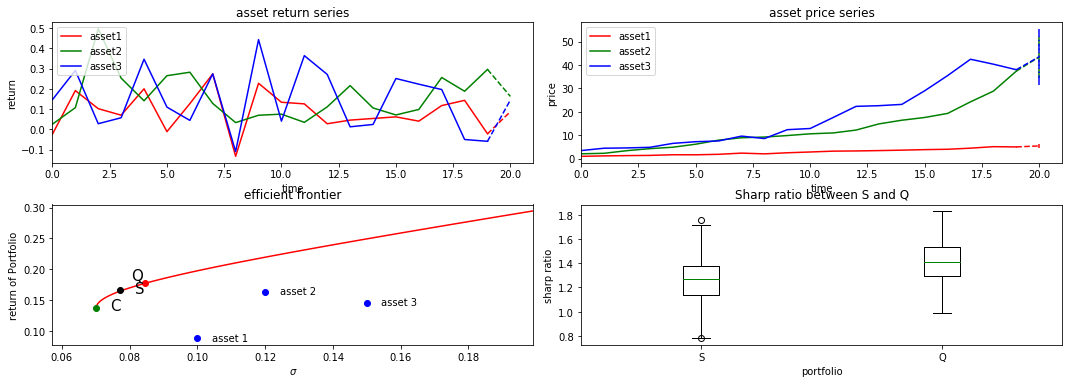

In [51]:
seed = 999
np.random.seed(seed)
# 真实收益率均值，用以生成数据，是不可观测的
true_mu = np.array([0.1,0.15,0.18])
true_sigma = np.array([0.1,0.12,0.15])
rou_ab, rou_ac, rou_bc = 0.25, 0.4, -0.3
true_C = np.array([ [1,      rou_ab,    rou_ac ],
                    [rou_ab,    1,      rou_bc],
                    [rou_ac,    rou_bc,   1   ]])
N = len(true_mu)
# 真实协方差矩阵，用以生成数据，是不可观测的
true_cov = np.outer(true_sigma,true_sigma)*true_C
def asset_generator(mean, cov, size=1):
    return np.random.multivariate_normal(mean, cov, size)
# 历史资产收益率历史
size = 20
asset_ret_obs = asset_generator(true_mu, true_cov, size=size)
N_obs = len(asset_ret_obs)
# 起初价格，可视化用
p0 = np.array([1,2,3])
# 还原历史价格序列
asset_price_obs = p0*np.exp(np.log(asset_ret_obs+1).cumsum(axis=0))
# 我们的收益预测模型
def mysterious_predict_model(asset_ret_obs,window=0):
    pred = asset_ret_obs[-window:,:].mean(axis=0)
    return pred
pred_ret = mysterious_predict_model(asset_ret_obs)
pred_price = asset_price_obs[-1,:]*(1+pred_ret)
estimate_cov = np.cov(asset_ret_obs.T) # 我们的协方差估计，不止这一种，这里只是示例
estimate_sigma = np.sqrt(np.diag(estimate_cov))
# 价格（－95%，95%）置信区间
pred_L, pred_H = asset_price_obs[-1,:]*(1+pred_ret-2*estimate_sigma), asset_price_obs[-1,:]*(1+pred_ret+2*estimate_sigma)

color_cycle = ['r', 'g', 'b']
mpl.rcParams['axes.color_cycle'] = color_cycle
plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
#for i in range(N):
plot1 = plt.plot(asset_ret_obs)
pred_pos=len(asset_ret_obs)
# 更新预测收益
for i in range(N):
    plt.plot([pred_pos-1,pred_pos],[asset_ret_obs[-1,i],pred_ret[i]],color_cycle[i]+'--')
plt.title('asset return series')
plt.xlabel('time')
plt.ylabel('return')
plt.xlim(0,N_obs+1)
plt.legend(plot1,['asset1', 'asset2', 'asset3'],loc='upper left')
plt.tight_layout()

plt.subplot(2,2,2)
plot2 = plt.plot(asset_price_obs)
# 更新预测价格
for i in range(N):
    plt.plot([pred_pos-1,pred_pos],[asset_price_obs[-1,i],pred_price[i]],color_cycle[i]+'--')
    plt.plot([pred_pos,pred_pos],[pred_L[i],pred_H[i]],color_cycle[i]+'-.') # 绘制置信区间
plt.title('asset price series')
plt.xlabel('time')
plt.ylabel('price')
plt.xlim(0,N_obs+1)
plt.legend(plot2,['asset1', 'asset2', 'asset3'],loc='upper left')
plt.tight_layout()

def our_strategy(pred_ret,V):     
    # 全额等额买入排名前50%的资产
    threshold = int(N/2)
    buy_list = (pred_ret.argsort()>=threshold)*1
    w_S = buy_list/buy_list.sum()
    sigma2_S = w_S.dot(V).dot(w_S)
    sigma_S = np.sqrt(sigma2_S)
    f_S = w_S.dot(f)
    return w_S,f_S,sigma_S

plt.subplot(2,2,3)
# 后面会用到
mu_estimator = pred_ret
cov_estimator = estimate_cov
plot_efficient_frontier(rf=rf,mu=pred_ret,V=estimate_cov, is_subplot=True,strategy=our_strategy)

initial_steps = 20
simulated_steps = 100
size = initial_steps+simulated_steps
loops = 200

SR_S_list = []
SR_Q_list = []
for _ in range(loops):
    simulated_return = asset_generator(true_mu, true_cov, size=size)

    actial_rp_S_history = []
    actial_rp_Q_history = []
    for current_step in range(initial_steps,simulated_steps):
        curr_ret_obs = simulated_return[:current_step,:] # 当前的可观测数据集
        # 利用固定窗口数据，不然我们的模型会越来越准确，这里希望我们的预测模型的预测能力是一致的
        pred_ret = mysterious_predict_model(curr_ret_obs,window=20)
        estimate_cov = np.cov(curr_ret_obs.T) 
        estimate_sigma = np.sqrt(np.diag(estimate_cov))

        f = pred_ret-rf 
        N = len(pred_ret)
        e = np.ones(N)
        V = estimate_cov
        V_inverse = np.linalg.inv(V)
        # 策略组合 , 全额等额买入排名前50%的资产
        w_S,f_S,sigma_S = our_strategy(pred_ret,V)
        # 最小方差组合
        w_C = V_inverse.dot(e)/e.T.dot(V_inverse).dot(e)
        sigma2_C = w_C.dot(V).dot(w_C)
        sigma_C = np.sqrt(sigma2_C)
        f_C = w_C.dot(f)
        # 夏普组合
        w_Q = V_inverse.dot(f)/f.T.dot(V_inverse).dot(f) * sigma2_C * f.T.dot(V_inverse).dot(f)/f_C
        sigma2_Q = w_Q.dot(V).dot(w_Q)
        sigma_Q = np.sqrt(sigma2_Q)
        f_Q = w_Q.dot(f)
        #计算实际损益
        actial_return = simulated_return[current_step+1,:]
        actial_rp_S = w_S.dot(actial_return)
        actial_rp_Q = w_Q.dot(actial_return)
        actial_rp_S_history.append(actial_rp_S)
        actial_rp_Q_history.append(actial_rp_Q)
    SR_S = (np.mean(actial_rp_S_history)-rf)/np.std(actial_rp_S_history)
    SR_Q = (np.mean(actial_rp_Q_history)-rf)/np.std(actial_rp_Q_history)
    SR_S_list.append(SR_S)
    SR_Q_list.append(SR_Q)
plt.subplot(2,2,4)
plt.boxplot(x=[SR_E_list,SR_Q_list],labels=['S','Q'])
plt.title('Sharp ratio between S and Q')
plt.xlabel('portfolio')
plt.ylabel('sharp ratio')

plt.show()

## 有效前沿的敏感性

下图是基于前面那个案例的预测有效前沿（上面的左下图）做了一个蒙特卡洛模拟从而得到的后验分布（方便点的话，理论上可以得到有效前沿的抛物线解析表达式，从而直接得到置信区间）。
具体的，我们根据之前的资产收益率和协方差的估计，作为我们风险资产的后验分布，然后我们根据资产后验分布模拟得到一组序列，并通过这组序列得到我们的有效前沿样本集。

我们看到，我们的有效前沿模拟样本分布在一个较“宽阔”的区间，问题我们想知道这个估计误差会对我们的投资决策产生什么样的重要影响？于是，在下图中还添加了Q、C的样本集。我们观察到，
它们共同的特征是在估计方差上的离散程度远大于估计收益率的离散程度。而Q组合最终要的性质莫过于与CML资本市场线相切（不展开，在下次的教程中会有更详细介绍），不用可视化我们也能看出来
将会对CML曲线造成非常大的影响，即CML对Q组合非常敏感。

我们上述分析揭示了有效前沿的敏感性问题，但并不是说我们要抛弃这个工具。基于有效前沿做组合优化，选择有效前沿上的资产组合仍然是一个明智的选择。因为不管有效前沿有多敏感，我们的估计误差已经
深入到资产预测与资产配置的整个流程当中，抛弃或偏离有效前沿工具并不能缩小我们的估计误差，并且偏离有效前沿的组合会在概率意义上始终劣于有效前沿上的组合。

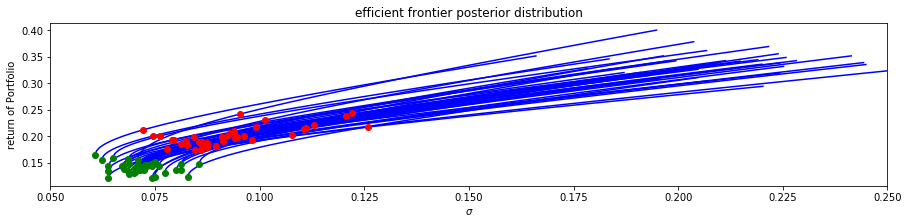

In [74]:
seed = 999
np.random.seed(seed)
# 有效前沿后验分布
Q_stats_list = []
C_stats_list = []

plt.figure(figsize=(15,3))
#plt.subplot(1,2,1)
for _ in range(40):
    # 利用我们之前的参数估计模拟资产收益和协方差矩阵
    asset_ret_obs = asset_generator(mu_estimator, cov_estimator, size=size)
    pred_ret = mysterious_predict_model(asset_ret_obs)
    estimate_cov = np.cov(asset_ret_obs.T) 
    estimate_sigma = np.sqrt(np.diag(estimate_cov))
    
    f = pred_ret-rf 
    N = len(pred_ret)
    e = np.ones(N)
    V = estimate_cov
    V_inverse = np.linalg.inv(V)
    
    # 最小方差组合
    w_C = V_inverse.dot(e)/e.T.dot(V_inverse).dot(e)
    sigma2_C = w_C.dot(V).dot(w_C)
    sigma_C = np.sqrt(sigma2_C)
    f_C = w_C.dot(f)
    # 夏普组合
    w_Q = V_inverse.dot(f)/f.T.dot(V_inverse).dot(f) * sigma2_C * f.T.dot(V_inverse).dot(f)/f_C
    sigma2_Q = w_Q.dot(V).dot(w_Q)
    sigma_Q = np.sqrt(sigma2_Q)
    f_Q = w_Q.dot(f)
    # 有效前沿曲线
    f_P = np.linspace(f_C,1.5*np.max(pred_ret)) # 只取上半部分抛物线
    get_w_P = lambda fp: (f_Q-fp)/(f_Q-f_C)*w_C + (fp-f_C)/(f_Q-f_C)*w_Q
    w_P = np.array([get_w_P(fp) for fp in f_P])
    k = (sigma2_Q-sigma2_C)/(f_Q-f_C)**2
    sigma2_P = sigma2_C + k*(f_P-f_C)**2
    sigma_P = np.sqrt(sigma2_P)
    r_P = rf + w_P.dot(f)
    # 缓存Q、C组合统计信息
    Q_stats_list.append((rf+f_Q,sigma_Q))
    C_stats_list.append((rf+f_C,sigma_C))
    # 有效前沿曲线绘制
    plt.plot(sigma_P,r_P,'b')
# 绘制Q、C样本
plt.plot(np.array(Q_stats_list)[:,1],np.array(Q_stats_list)[:,0],'ro')
plt.plot(np.array(C_stats_list)[:,1],np.array(C_stats_list)[:,0],'go')
plt.title('efficient frontier posterior distribution')
plt.xlabel('$\sigma$')
plt.ylabel('return of Portfolio')
plt.xlim(0.05,0.25)

plt.show()

## 总结

在总结之前，我再重述下有效前沿或者均值方差分析的假设和限制：
- 我们这里假设的是单期投资的情况，这个假设可以被放宽，大致不影响我们的结论和分析过程
- 我们虽然做了无交易成本假设，但是在实践中是需要考虑的，也是可以被建模的
- 我们上述分析暗含了自融假设，即可以通过建立空头头寸为多头融资，这个在实践中往往是有限制和不允许的
我们上述分析过程有个小问题，我们虽然做了全额投资假设，然而我们允许使用杠杆头寸

最后，总结一下我的观点：

- 有效前沿是有用的工具，所有风险厌恶的投资者都应该考虑它
- 有效前沿是均值方差最优的机会集，是最小风险组合与最优夏普组合的线性组合
- 有效前沿有敏感性问题，尤其是最优夏普组合的估计误差会对CML及CAPM造成较大影响
- 在多资产、多策略的情境下，有效前沿是一个资产配置或者头寸管理的一个较好的出发点
- 有效前沿在大量数据、大量资产的情况下，基于计算复杂度和参数估计误差（需要估计的参数实在太多了），难以直接使用

## 附录

#### 分块矩阵求逆定理

A,D分别是mxm,nxn的可逆矩阵,M是(m+n)x(m_n)的分块矩阵：

\begin{align*}
M = 
  \begin{pmatrix} 
    A & B\\  
    C & D  
  \end{pmatrix}                
\end{align*}

它的逆矩阵：

\begin{align*} 
M^{-1} = 
  \begin{pmatrix} 
    (A-BD^{-1}C)^{-1}         & -A^{-1}B(D-CA^{-1}B)^{-1}\\  
    -D^{-1}C(A-BD^{-1}C)^{-1} & (D-CA^{-1}B)^{-1}  
  \end{pmatrix}                
\end{align*}

#### 最小方差组合推导

重述我们的问题：

\begin{align*}
Minimize \qquad & \frac{1}{2} \boldsymbol{w^{T} \Sigma w}\\
s.t \qquad      & \boldsymbol{w^{T}} \boldsymbol{e} = 1
\end{align*}

于是我们引入拉格朗日乘子$l$，

\begin{align*}
L(l,w) = \frac{1}{2} \boldsymbol{w^{T} \Sigma w} - l ( \boldsymbol{w^{T}} \boldsymbol{e} - 1)
\end{align*}

分别对$\boldsymbol{w}$和$l$进行求导：

\begin{align*}
\frac{\partial L(l,w)}{\partial \boldsymbol{w}}       &= \boldsymbol{\Sigma w} - l \boldsymbol{e} = \boldsymbol{0}\\
\frac{\partial L(l,w)}{\partial \boldsymbol{\lambda}} &= \boldsymbol{w^{T}} \boldsymbol{e}  - 1 = 0
\end{align*}

上述实际上是两组方程组，我们用矩阵形式重新表达：

\begin{align*}
\begin{pmatrix} 
    \boldsymbol{\Sigma}   & \boldsymbol{e}\\  
    \boldsymbol{e^T}      & 0
\end{pmatrix}
\begin{pmatrix} 
    \boldsymbol{w}\\    
    -l
\end{pmatrix}
  &= 
\begin{pmatrix} 
    \boldsymbol{0}\\    
    1
\end{pmatrix}\\
\begin{pmatrix} 
    \boldsymbol{w}\\    
    -l
\end{pmatrix}
  &= 
\begin{pmatrix} 
    \boldsymbol{\Sigma}   & \boldsymbol{e}\\  
    \boldsymbol{e^T}      & 0
\end{pmatrix}^{-1}
\begin{pmatrix} 
    \boldsymbol{0}\\    
    1
\end{pmatrix}
\end{align*}

利用上面的分块矩阵求逆定理：

\begin{align*}
\begin{pmatrix} 
    \boldsymbol{\Sigma}   & \boldsymbol{e}\\  
    \boldsymbol{e^T}      & 0
\end{pmatrix}^{-1}
 = 
\begin{pmatrix} 
    \boldsymbol{\Sigma}^{-1}   & \frac{\boldsymbol{\Sigma^{-1} e}}{\boldsymbol{e^{T} \Sigma^{-1} e}}\\  
    0                          & -\frac{1}{\boldsymbol{e^{T} \Sigma^{-1} e}}
\end{pmatrix}
\end{align*}

代入上式：

\begin{align*}
\begin{pmatrix} 
    \boldsymbol{w}\\    
    -l
\end{pmatrix}
  &= 
\begin{pmatrix} 
    \boldsymbol{\Sigma}^{-1}   & \frac{\boldsymbol{\Sigma^{-1} e}}{\boldsymbol{e^{T} \Sigma^{-1} e}}\\  
    0                          & -\frac{1}{\boldsymbol{e^{T} \Sigma^{-1} e}}
\end{pmatrix}
\begin{pmatrix} 
    \boldsymbol{0}\\    
    1
\end{pmatrix}\\
  &=
\begin{pmatrix} 
    \frac{\boldsymbol{\Sigma^{-1} e}}{\boldsymbol{e^{T} \Sigma^{-1} e}}\\  
    -\frac{1}{\boldsymbol{e^{T} \Sigma^{-1} e}}
\end{pmatrix}
\end{align*}

整理下，便得到了我们的最终解：

\begin{align*}
\begin{pmatrix} 
    \boldsymbol{w}\\    
    l
\end{pmatrix}
  &=
\begin{pmatrix} 
    \frac{\boldsymbol{\Sigma^{-1} e}}{\boldsymbol{e^{T} \Sigma^{-1} e}}\\  
    \frac{1}{\boldsymbol{e^{T} \Sigma^{-1} e}}
\end{pmatrix}
\end{align*}

#### 最优夏普组合的推导

待完善

## 参考文献

1. 《主动投资组合管理》第二章
2. 《Quantitative Equity Portfolio Management Modern Techniques and Applications》Ch02
3. 《Portfolio Theory Matrix》https://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf
4. 《Mean-Variance Portfolio Analysis and the Capital Asset Pricing Model》https://www2.isye.gatech.edu/~shackman/isye4311_Fall_2011/MVA_CAPM.pdf
 